In [ ]:
import os
import cv2
import numpy as np
import random

def patch_batch_generator(file_list, image_dir, density_dir,
                           input_size=(1024, 1024), patch_size=512, batch_size=8, output_size=64):
    h_img, w_img = input_size

    while True:
        image_batch = []
        density_batch = []

        while len(image_batch) < batch_size:
            
            image_file = random.choice(file_list)

            image_path = os.path.join(image_dir, image_file)
            density_path = os.path.join(density_dir, image_file.replace('.jpg', '.npy'))

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (w_img, h_img))
            image_norm = image / 255.0

            
            density = np.load(density_path)
            old_h, old_w = density.shape

            density_resized = cv2.resize(density, (w_img, h_img), interpolation=cv2.INTER_LINEAR)
            scaling_factor = (old_h * old_w) / (h_img * w_img)
            density_resized = density_resized * scaling_factor

            x_max = w_img - patch_size
            y_max = h_img - patch_size
            x = random.randint(0, x_max)
            y = random.randint(0, y_max)

            image_patch = image_norm[y:y+patch_size, x:x+patch_size, :]
            density_patch = density_resized[y:y+patch_size, x:x+patch_size]

            density_patch_resized = cv2.resize(density_patch, (output_size, output_size), interpolation=cv2.INTER_LINEAR)
     
            density_patch_resized *= (patch_size * patch_size) / (output_size * output_size)
            density_patch_resized = np.expand_dims(density_patch_resized, axis=-1)

            image_batch.append(image_patch)
            density_batch.append(density_patch_resized)

        yield np.array(image_batch), np.array(density_batch)

image_dir= '/content/drive/MyDrive/images'
density_dir = '/content/drive/MyDrive/train_data_sigma_9/'

image_files = os.listdir(image_dir)
image_files = [f for f in image_files if f.endswith('.jpg')]

from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(image_files, test_size=0.1, random_state=42)

train_gen = patch_batch_generator(train_files, image_dir, density_dir, batch_size=8)
val_gen = patch_batch_generator(val_files, image_dir, density_dir, batch_size=8)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam

class CBAMLayer(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel = input_shape[-1]
        self.shared_dense_one = tf.keras.layers.Dense(self.channel // self.reduction_ratio,
                                                      activation='relu')
        self.shared_dense_two = tf.keras.layers.Dense(self.channel)

        self.conv_spatial = tf.keras.layers.Conv2D(filters=1,
                                                   kernel_size=7,
                                                   padding='same',
                                                   activation='sigmoid')

    def call(self, inputs):

        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        scale = tf.nn.sigmoid(avg_out + max_out)
        x = inputs * scale

        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        scale = self.conv_spatial(concat)
        x = x * scale
        return x

Model_Input=Input(shape=(None, None,3))
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(None, None,3))

conv_base = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)

conv_base.summary()

x = conv_base(Model_Input)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 7,635,264 (29.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
p1 = CBAMLayer()(x)
a1=Conv2D(256,3,padding='same',activation='relu')(p1) # skip connections
a2=Conv2D(256,3,padding='same',activation='relu')(a1)
a3=Conv2D(128,3,padding='same',activation='relu')(a2)
a4=Conv2D(128,3,padding='same',activation='relu')(a3)
a5=Conv2D(64,3,padding='same',activation='relu')(a4)

b1=Conv2D(256,5,padding='same',activation='relu')(p1)
b2=Conv2D(256,5,padding='same',activation='relu')(b1)
b3=Conv2D(128,3,padding='same',activation='relu')(b2)
b4=Conv2D(64,3,padding='same',activation='relu')(b3)

# c1=Conv2D(512,5,padding='same',activation='relu')(p1)
# c2=Conv2D(256,3,padding='same',activation='relu')(c1)
# c3=Conv2D(128,3,padding='same',activation='relu')(c2)
# c4=Conv2D(64,1,padding='same',activation='relu')(c3)

merged_ouput=concatenate([a5,b4])
d1=CBAMLayer()(merged_ouput)
e1=Conv2D(1,1)(d1)

model=Model(inputs=Model_Input,outputs=e1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, None,      │  7,635,264 │ input_layer[0][0] │
│ (Functional)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_layer          │ (None, None,      │     66,211 │ functional[0][0]  │
│ (CBAMLayer)         │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │  1,179,904 │ cbam_layer[0][0]  │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │    590,080 │ conv2d_1[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │  3,277,056 │ cbam_layer[0][0]  │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │    295,040 │ conv2d_2[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │  1,638,656 │ conv2d_6[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    147,584 │ conv2d_3[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │    295,040 │ conv2d_7[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     73,792 │ conv2d_4[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, None,      │     73,792 │ conv2d_8[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ None, 128)        │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_layer_1        │ (None, None,      │      4,339 │ concatenate[0][0] │
│ (CBAMLayer)         │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, None,      │        129 │ cbam_layer_1[0][… │
│                     │ None, 1)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,276,887 (58.28 MB)

 Trainable params: 15,276,887 (58.28 MB)

 Non-trainable params: 0 (0.00 B)

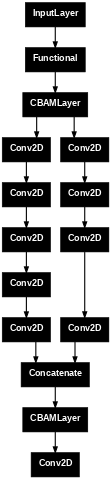

In [10]:
from keras.utils import plot_model
plot_model(model,dpi=40)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

# Compile model with Adam optimizer and MSE loss + MAE metric
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='mse',
    metrics=[MeanAbsoluteError()]
)

# EarlyStopping on training loss (lower is better)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Reduce learning rate on plateau (training loss)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-8
)

# Train the model using generators
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=100,
    validation_steps=10,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - loss: 5.5916e-04 - mean_absolute_error: 0.0064 - val_loss: 4.9863e-04 - val_mean_absolute_error: 0.0081 - learning_rate: 1.0000e-05
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 842ms/step - loss: 3.9558e-04 - mean_absolute_error: 0.0077 - val_loss: 6.6960e-04 - val_mean_absolute_error: 0.0102 - learning_rate: 1.0000e-05
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 6.5075e-04 - mean_absolute_error: 0.0092 - val_loss: 5.9982e-04 - val_mean_absolute_error: 0.0093 - learning_rate: 1.0000e-05
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 841ms/step - loss: 4.3754e-04 - mean_absolute_error: 0.0084 - val_loss: 3.6519e-04 - val_mean_absolute_error: 0.0080 - learning_rate: 1.0000e-05
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 4.1698e-04 - mean_absolute_error: 0.0081 - val_loss: 3.4059e-04 - val_mean_absolute_error: 0.0067 - learning_rate: 1.0000e-05
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - 

In [ ]:
for file in test_files:
    image_path = os.path.join(test_image_dir, file)
    gt_path = os.path.join(test_gt_dir, "GT_" + file.replace(".jpg", ".mat"))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    points = load_ground_truth(gt_path)

    image_resized, gt_points_rescaled = resize_image_and_gt(image, points)

    predicted_total_count = 0
    gt_total_count = 0

    for i in range(2):  
        for j in range(2): 
            x_start = j * patch_size
            y_start = i * patch_size
            x_end = x_start + patch_size
            y_end = y_start + patch_size

           
            image_patch = image_resized[y_start:y_end, x_start:x_end, :]
            image_patch_input = preprocess_image_patch(image_patch)

            predicted_density = model.predict(image_patch_input)
            predicted_density = np.squeeze(predicted_density)
            predicted_patch_count = predicted_density.sum()
            predicted_total_count += predicted_patch_count

            gt_patch_points = []
            for pt in gt_points_rescaled:
                if x_start <= pt[0] < x_end and y_start <= pt[1] < y_end:
                    gt_patch_points.append([pt[0] - x_start, pt[1] - y_start])
            gt_patch_count = len(gt_patch_points)
            gt_total_count += gt_patch_count

    error = abs(predicted_total_count - gt_total_count)
    total_absolute_error += error
    total_samples += 1

    print(f"Image: {file}")
    print(f"Predicted Count: {predicted_total_count:.2f}")
    print(f"Ground Truth Count: {gt_total_count}")
    print(f"Absolute Error: {error:.2f}\n")

mae = total_absolute_error / total_samples
print(f"Mean Absolute Error on test set: {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image: IMG_1.jpg
Predicted Count: 22.67
Ground Truth Count: 23
Absolute Error: 0.33

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Image: IMG_278.jpg
Predicted Count: 37.97
Ground Truth Count: 57
Absolute Error: 19.03

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Image: IMG_188.jpg
Predicted Count: 45.94
Ground Truth Count: 56
Absolute Error: 10.06

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Image: IMG_264.jpg
Predicted Count: 29.36
Ground Truth Count: 36
Absolute Error: 6.64

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 